In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%cd -q ..

In [4]:
import lcpfn
import torch
import numpy as np
from matplotlib import pyplot as plt

print(torch.__version__)

/home/antonio14bernardes/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


2.2.2+cu121


# Training the LCPFN

In [ ]:
%pip install torch==1.11.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 2.1 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.2.1+cu121
    Uninstalling torch-2.2.1+cu121:
      Successfully uninstalled torch-2.2.1+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchdata 0.7.1 requires torch>=2, but you have torch 1.11.0 which is incompatible.
torchtext 0.17.1 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.
torchvision 0.17.1+cu121 requires torch==2.2.1, but you have torch 1.11.0 which is incompatible.


In [ ]:
get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)

# They tried
# emsize ∈ [128, 256, 512]
# nlayers ∈ [3, 6, 12]
# nb_data ∈ [100k, 1M, 10M]
# steps_per_epoch is hardcoded to 100
# num_epochs?

result = lcpfn.train_lcpfn(get_batch_func=get_batch_func,
                          seq_len=100,
                         emsize=256,
                         nlayers=3,
                         num_borders=1000,
                         lr=0.001,
                         batch_size=500,
                         epochs=100)

transformer_model = result[2]



Using 1000000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using cuda:0 device
init dist
Not using distributed
DataLoader.__dict__ {'num_steps': 100, 'get_batch_kwargs': {'batch_size': 500, 'eval_pos_seq_len_sampler': <function train.<locals>.eval_pos_seq_len_sampler at 0x7eec9fe0f0a0>, 'seq_len_maximum': 100, 'device': 'cuda:0', 'num_features': 1, 'hyperparameters': {}}, 'num_features': 1}
Style definition: None
Using a Transformer with 2.23 M parameters


/content/drive/MyDrive/lcpfn/lcpfn/bar_distribution.py:22: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at  ../aten/src/ATen/native/BucketizationUtils.h:28.)
  target_sample = torch.searchsorted(self.borders, y) - 1


-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 46.40s | mean loss -0.07 | pos losses   nan,-0.06,-0.06,-0.05,  nan,  nan,-0.06,-0.06,-0.07,-0.06,  nan,-0.13,  nan,-0.10,-0.04,-0.06,  nan,-0.07,-0.07,-0.06,-0.05,-0.06,-0.08,  nan,-0.08,-0.09,-0.04,-0.07,-0.07,  nan,-0.10,-0.03,-0.07,  nan,-0.05,-0.06,  nan,-0.04,-0.07,-0.07,-0.08,  nan,  nan,  nan,-0.04,-0.07,-0.06,-0.07,  nan,-0.05,  nan,-0.08,-0.07,-0.07,  nan,-0.05,-0.06,  nan,-0.07,-0.05,  nan,  nan,-0.06,-0.08,-0.05,-0.09,-0.06,-0.05,-0.07,  nan,-0.09,-0.09,  nan,-0.06,  nan,  nan,  nan,  nan,  nan,-0.06,  nan,  nan,  nan,-0.05,-0.07,-0.06,-0.08,-0.08,-0.06,-0.04,  nan,  nan,  nan,-0.04,  nan,-0.06,  nan,-0.06,  nan,-0.08, lr 0.0 data time  0.33 step time  0.10 forward time  0.01
-----------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------
| end 

In [ ]:
model_save_path = "lcpfn/trained_models/"+"reproduction_model.pt"

In [ ]:
# Save the model

torch.save(transformer_model, model_save_path)

# Getting the lc data

In [8]:


# Get the data for cutoff 10 inference
prior_10 = lcpfn.sample_from_prior(np.random)
curve_10, _ = prior_10()
x_10 = torch.arange(1, 101).unsqueeze(1)
y_10 = torch.from_numpy(curve_10).float().unsqueeze(1)
cutoff_10 = 10
data_10 = {'x': x_10, 'y': y_10, 'cutoff': cutoff_10}

# Get the data for cutoff 20 inference
prior_20 = lcpfn.sample_from_prior(np.random)
curve_20, _ = prior_20()
x_20 = torch.arange(1, 101).unsqueeze(1)
y_20 = torch.from_numpy(curve_20).float().unsqueeze(1)
cutoff_20 = 20
data_20 = {'x': x_20, 'y': y_20, 'cutoff': cutoff_20}

# Inference with LCPFN

In [ ]:
# Load trained model
lcpfn_model = lcpfn.LCPFN(model_save_path)

# Predictions for cutoff = 10
x = data_10['x']
y = data_10['y']
cutoff = data_10['cutoff']
predictions_10 = lcpfn_model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

# Predictions for cutoff = 20
x = data_20['x']
y = data_20['y']
cutoff = data_20['cutoff']
predictions_20 = lcpfn_model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])





Text(0, 0.5, 'Y')

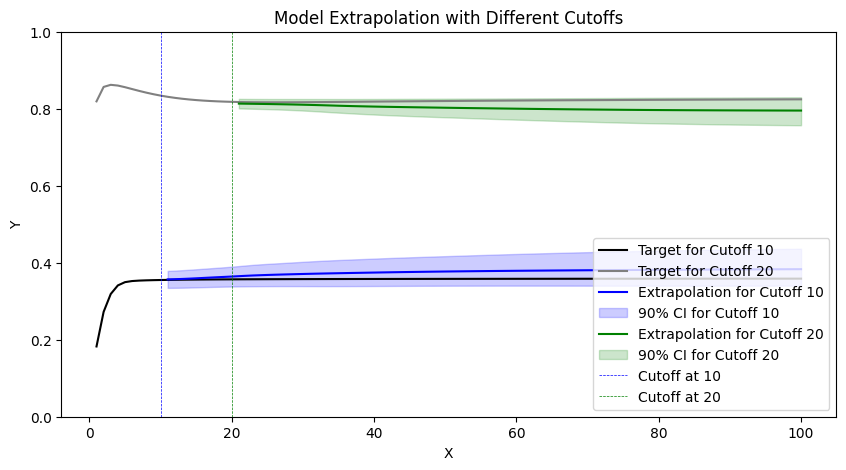

In [ ]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot target curves
plt.plot(x_10, y_10, "black", label="Target for Cutoff 10")
plt.plot(x_20, y_20, "grey", label="Target for Cutoff 20")

# Plot extrapolations
plt.plot(x_10[cutoff_10:], predictions_10[:, 1], "blue", label="Extrapolation for Cutoff 10")
plt.fill_between(x_10[cutoff_10:].flatten(), predictions_10[:, 0], predictions_10[:, 2], color="blue", alpha=0.2, label="90% CI for Cutoff 10")

plt.plot(x_20[cutoff_20:], predictions_20[:, 1], "green", label="Extrapolation for Cutoff 20")
plt.fill_between(x_20[cutoff_20:].flatten(), predictions_20[:, 0], predictions_20[:, 2], color="green", alpha=0.2, label="90% CI for Cutoff 20")

# Plot cutoff lines
plt.axvline(x=cutoff_10, color='blue', linestyle='--', linewidth=0.5, label='Cutoff at 10')
plt.axvline(x=cutoff_20, color='green', linestyle='--', linewidth=0.5, label='Cutoff at 20')

plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.title("Model Extrapolation with Different Cutoffs")
plt.xlabel("X")
plt.ylabel("Y")

# Inference with MCMC

In [5]:
%pip install torch --upgrade
%pip install gpytorch
%pip install botorch

Requirement already up-to-date: torch in /home/antonio14bernardes/.local/lib/python3.8/site-packages (2.2.2)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [6]:
from lcpfn.priors.fast_gp_mix import get_model


def get_mcmc_model_variable_chains(x, y, hyperparameters, device, num_samples, warmup_steps, num_chains, obs=True):
    from pyro.infer.mcmc import NUTS, MCMC, HMC
    import pyro
    x = x.to(device)
    y = y.to(device)
    model, likelihood = get_model(x, y, hyperparameters, sample=False)
    model.to(device)


    def pyro_model(x, y):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        if obs:
            return pyro.sample("obs", output, obs=y)

    nuts_kernel = NUTS(pyro_model)
    mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)#num_chains=1)
    mcmc_run.run(x, y)
    model.pyro_load_from_samples(mcmc_run.get_samples()) # pyro.infer wie noah?
    model.eval()

    return model, likelihood

In [10]:

# They tried
# nsamples ∈ [100, 250, 500, 1000, 2000, 4000]
# nwalkers ∈ [26, 50, 100]
# burn-in ∈ [0, 50, 100, 500]
# thin ∈ [1, 10, 100]

hyperparameters = {'handmade': True} # Use the default handmade hyperparameters chosen by the authors
device = 'cpu'
num_samples = 100
warmup_steps = 10
num_chains = 100

# For a cutoff of 10
x = data_10['x']
y = data_10['y']
cutoff = data_10['cutoff']
mcmc_model_10, likelihood_10 = get_mcmc_model_variable_chains(x[:cutoff].float(), y.flatten()[:cutoff].float(), hyperparameters, device, num_samples, warmup_steps, num_chains)
with torch.no_grad():
    predictions_10 = likelihood_10(mcmc_model_10(x[cutoff:].float()))
    pred_mean_10 = predictions_10.mean.mean(0).squeeze()
    pred_lower_10, pred_upper_10 = predictions_10.confidence_region()
    pred_lower_10 = pred_lower_10.mean(0).squeeze()
    pred_upper_10 = pred_upper_10.mean(0).squeeze()

# For a cutoff of 20
x = data_20['x']
y = data_20['y']
cutoff = data_20['cutoff']
mcmc_model_20, likelihood_20 = get_mcmc_model_variable_chains(x[:cutoff].float(), y.flatten()[:cutoff].float(), hyperparameters, device, num_samples, warmup_steps, num_chains)
with torch.no_grad():
    predictions_20 = likelihood_20(mcmc_model_10(x[cutoff:].float()))
    pred_mean_20 = predictions_20.mean.mean(0).squeeze()
    pred_lower_20, pred_upper_20 = predictions_20.confidence_region()
    pred_lower_20 = pred_upper_20.mean(0).squeeze()
    pred_upper_20 = pred_upper_20.mean(0).squeeze()


pred_mean_10, pred_mean_20

/home/antonio14bernardes/.local/lib/python3.8/site-packages/pyro/infer/mcmc/api.py:499: UserWarning: num_chains=100 is more than available_cpu=7. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/110 [00:00, ?it/s]

Sample [0]:  63%|██████▎   | 69/110 [00:15,  4.67it/s, step size=9.11e-01, acc. prob=0.858]

KeyboardInterrupt: 

In [ ]:
# Plotting the data and predictions
plt.figure(figsize=(12, 6))

# Plot predictions for cutoff = 10
plt.plot(data_10['x'].flatten(), data_10['y'].flatten(), "gray", label="Data for Cutoff 10")  # Actual data
plt.plot(data_10['x'][data_10['cutoff']:].flatten(), pred_mean_10, "blue", label="Extrapolation for Cutoff 10")
plt.fill_between(data_10['x'][data_10['cutoff']:].flatten(), pred_lower_10, pred_upper_10, color="blue", alpha=0.2, label="90% CI for Cutoff 10")

# Plot predictions for cutoff = 20
plt.plot(data_20['x'].flatten(), data_20['y'].flatten(), "lightgray", label="Data for Cutoff 20")  # Actual data
plt.plot(data_20['x'][data_20['cutoff']:].flatten(), pred_mean_20, "green", label="Extrapolation for Cutoff 20")
plt.fill_between(data_20['x'][data_20['cutoff']:].flatten(), pred_lower_20, pred_upper_20, color="green", alpha=0.2, label="90% CI for Cutoff 20")

# Plot cutoff lines
plt.axvline(x=data_10['cutoff'], color='blue', linestyle='--', linewidth=0.5, label='Cutoff at 10')
plt.axvline(x=data_20['cutoff'], color='green', linestyle='--', linewidth=0.5, label='Cutoff at 20')

# Set plot limits, labels, title and legend
plt.ylim(0, 1)
plt.xlabel("X-axis")
plt.ylabel("Predicted Values")
plt.title("MCMC Model Extrapolation with Different Cutoffs")
plt.legend(loc="upper left")